### Appendiks A

Laster inn data fra de ulike mottakerene (har et script som lager array fra kml filer). Data fra arduino-enheten filtreres til å kun inneholde koordinater fra når den faktisk lå på referansepunktet.

In [1]:
%run kml_to_arr.py

# Laster først inn  et script som er utformet til lage array fra datasettene

rtk_arr = extract_coordinates_kml_RTK(
    'dataset/sammenlikning_gnss/RTK_gnss_mottaker.kml'
    )
mobil_arr = extract_coordinates_kml_mobil(
    'dataset/sammenlikning_gnss/mobiltelefon_gnss_motaker.kml'
    )
arduino_arr = extract_coordinates_kml_arduino(
    'dataset/sammenlikning_gnss/arduino_gnss_mottaker.kml'
    )

# Korrigerer arduino array for veldig missvisende førstepunkter 
# (kom anntakelig fra merging av filer, 
# samt at enhetene bruker tid på å instille seg)

arduino_arr = arduino_arr[60:]
mobil_arr = mobil_arr[60:]


Lager en funksjon som konverterer lengde- og breddegrad til UTM32 formatet. Slik at vi får standardavvik i meter.

In [2]:
import pyproj

def convert_to_utm32(coord_pairs):
    # Define the UTM32 (Zone 32N) projection 
    utm_proj = pyproj.Proj(proj='utm', zone=32, ellps='WGS84', south=False)

    # Convert the coordinates and return the combined UTM coordinates
    return list(zip(*utm_proj(*zip(*coord_pairs))))

Ønsker så å plotte data for oversikt. Har laget eget script for dette.

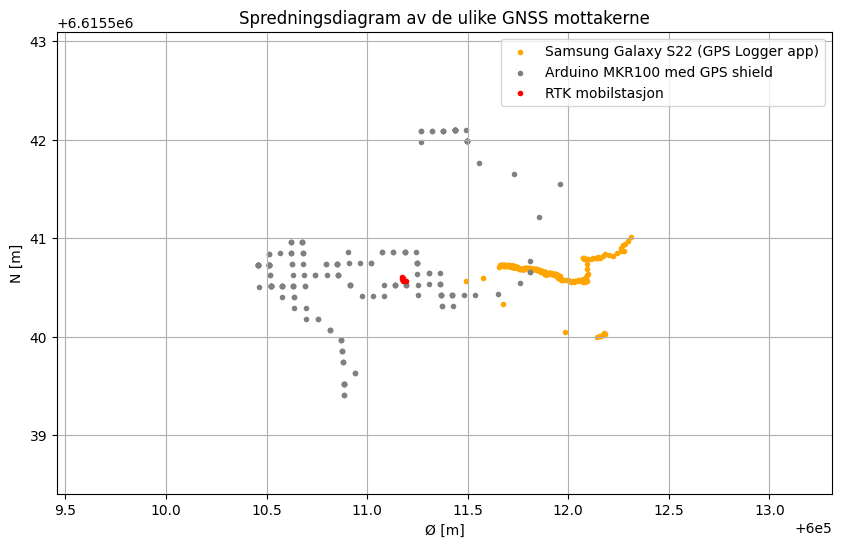

In [3]:
%run coordinates_scatterplot.py

plot_multiple_coordinates(
    convert_to_utm32(mobil_arr), 
    convert_to_utm32(arduino_arr),
    convert_to_utm32(rtk_arr),  
    labels=[
        'Samsung Galaxy S22 (GPS Logger app)', 
        'Arduino MKR100 med GPS shield',
        'RTK mobilstasjon'
    ], 
    colors=[
        'orange', 
        'grey', 
        'red'
    ]
)


Ønsker så å lage en tabell over ulike verdier knyttet til målingene

In [4]:
import numpy as np
import pandas as pd

data = {
    'RTK': convert_to_utm32(rtk_arr),
    'Mobiltelefon': convert_to_utm32(mobil_arr),
    'Arduino-enhet': convert_to_utm32(arduino_arr),
}

# Signifikante tall for hver målemetode (i henhold til nøyaktighet i fil)
# Disse verdiene er funnet ved hvor nøyaktige koordinatene er i filen
# Og hvor mange meter nøyaktigheten i lengde-og breddegrader tilsvarer
# Feks  ved 8 desimalpunkter i koordinatet, 
# så målingens nøyaktighet på milimeternivå

precision_dict = {
    'RTK': 3,
    'Mobiltelefon': 3,
    'Arduino-enhet': 2
}

# Finner gjennomsnittskoordinat og standardavvik
def analyze_coordinates(arr, method=''):
    arr_mean = np.mean(arr, axis=0)
    arr_std = np.std(arr, axis=0)
    arr_size = len(arr)
    return [method, arr_size, arr_mean, arr_std]

# Funksjon for å finne avrunde avledede enheter til rette sifnifikant tall
def adjust_significant_figures(value, precision):
    if isinstance(value, list):
        return [round(v, precision) for v in value]
    return round(value, precision)

# Lager en dataframe og skriver en csv fil
def create_dataframe(coord_dict):
    data_list = []
    for method, arr in coord_dict.items():
        _, arr_size, arr_mean, arr_std = analyze_coordinates(arr, method)
        row = [method, arr_size, arr_mean.tolist(), arr_std.tolist()]
        data_list.append(row)
    df = pd.DataFrame(data_list, columns=[
                      'Metode', 'Antall punkter', 'Gjennomsnitt [m]', 'Standardavvik [m]'])

    # Anvender signifikante tall funksjonen
    df['Gjennomsnitt [m]'] = df.apply(lambda row: adjust_significant_figures(
        row['Gjennomsnitt [m]'], precision_dict[row['Metode']]), axis=1)
    df['Standardavvik [m]'] = df.apply(lambda row: adjust_significant_figures(
        row['Standardavvik [m]'], precision_dict[row['Metode']]), axis=1)


    # Skriver til fil
    df.to_csv('dataset/coordinates_analysis.csv', index=False)

    return df


display(create_dataframe(data))

,Metode,Antall punkter,Gjennomsnitt [m],Standardavvik [m]
0,RTK,7,"[600011.179, 6615540.58]","[0.006, 0.015]"
1,Mobiltelefon,273,"[600011.881, 6615540.661]","[0.157, 0.134]"
2,Arduino-enhet,194,"[600010.98, 6615540.74]","[0.37, 0.63]"


Plotter så de ønskede verdiene ved bruk av et plottescript som lastes inn:

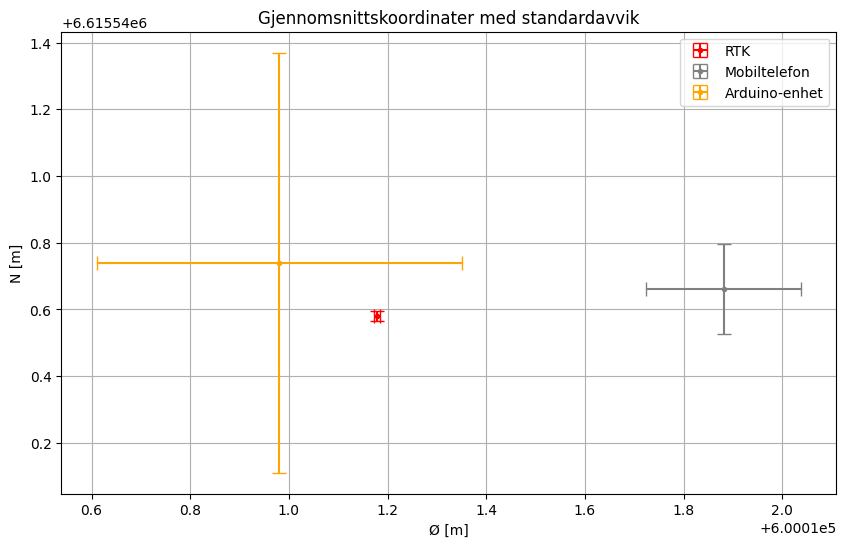

In [5]:
%run plot_with_errorbars.py

plot_coordinates_with_error_bars(create_dataframe(data))